In [1]:
import os
import numpy as np          
import pandas as pd              
import matplotlib.pyplot as plt  
import random
import tensorflow.keras as keras

# configure notebook to display plots
%matplotlib inline

# set up user paths
data_dir = 'E:/Subjects/Neural/Modelling_Time_series_data/data/'
csv_dir = 'E:/Subjects/Neural/Modelling_Time_series_data/csv/'

In [2]:
# Fetch the DataFrame's loaded in the problem setup
X_train=np.load('X_train_prepared.npy')
y_train=np.load('y_train_prepared.npy')
X_valid=np.load('X_valid_prepared.npy')
y_valid=np.load('y_valid_prepared.npy')

In [3]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Masking
from tensorflow.keras.optimizers import RMSprop

# construct inputs
x = Input((None, X_train.shape[-1]) , name='input')
mask = Masking(0, name='input_masked')(x)

# stack LSTMs
lstm_kwargs = {'dropout': 0.25, 'recurrent_dropout': 0.1, 'return_sequences': True, 'implementation': 2}
lstm1 = LSTM(128, name='lstm1', **lstm_kwargs)(mask)

# output: sigmoid layer
output = TimeDistributed(Dense(1, activation='sigmoid'), name='output')(lstm1)
model = Model(inputs=x, outputs=output)

# compile model
optimizer = RMSprop(lr=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# print layer shapes and model parameters
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 265)]       0         
                                                                 
 input_masked (Masking)      (None, None, 265)         0         
                                                                 
 lstm1 (LSTM)                (None, None, 128)         201728    
                                                                 
 output (TimeDistributed)    (None, None, 1)           129       
                                                                 
Total params: 201,857
Trainable params: 201,857
Non-trainable params: 0
_________________________________________________________________


In [4]:
# this will take a while...
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1)

Epoch 1/5
40/40 [==============================] - 408s 10s/step - loss: 0.2767
Epoch 2/5
40/40 [==============================] - 557s 14s/step - loss: 0.2042
Epoch 3/5
40/40 [==============================] - 618s 15s/step - loss: 0.1786
Epoch 4/5
40/40 [==============================] - 637s 16s/step - loss: 0.1608
Epoch 5/5
40/40 [==============================] - 737s 18s/step - loss: 0.1438


In [5]:
# Generate model results on the holdout validation set
preds = model.predict(X_valid)

85/85 [==============================] - 30s 352ms/step


In [6]:
preds.shape

(2690, 500, 1)

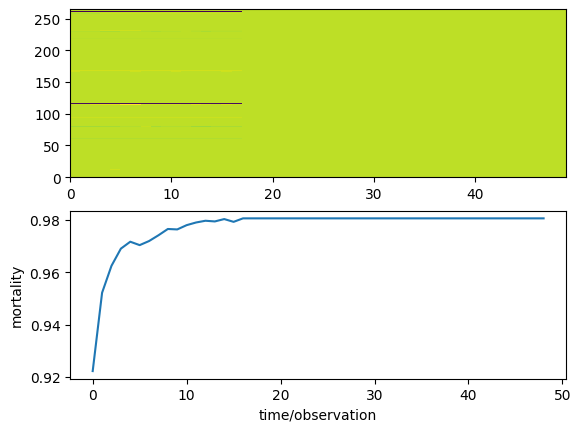

In [8]:
# Figure out how many encounters we have
numencnt = X_valid.shape[0]

# Choose a random patient encounter to plot
ix = random.randint(0,numencnt-1)

# Create axis side by side
f, (ax1, ax2) = plt.subplots(2, 1)

# Plot the observation chart for the random patient encounter
ax1.pcolor(np.transpose(X_valid[ix,1:50,:]))
ax1.set_ylim(0,265)
plt.ylabel("mortality")
plt.xlabel("time/observation")

# Plot the patient survivability prediction
ax2.plot(preds[ix,1:50]);

In [9]:
from sklearn.metrics import roc_curve, auc

# get 0/1 binary label for each patient encounter
label = y_valid[:, 0, :].squeeze();

# get the last prediction in [0,1] for the patient
prediction = preds[:, -1, :].squeeze()

# compute ROC curve for predictions
rnn_roc = roc_curve(label,prediction)

# compute the area under the curve of prediction ROC
rnn_auc = auc(rnn_roc[0], rnn_roc[1])

In [11]:
# scores for baselines PRISM3 and PIM2 were aggregated and stored in `data/pim2prism3.csv`.
# load the scores and then compute the ROC curves and AUC
index = pd.read_csv(os.path.join('E:/Subjects/Neural/Modelling_Time_series_data/csv/', 'pim2prism3.csv'))

# get the mortality reponse for each patient
mortrep = index['mortalityResponse'];

# generate ROC curves for each index
pim2_roc   = roc_curve(mortrep, -index['PIM2'  ])
prism3_roc = roc_curve(mortrep, -index['PRISM3'])

# compute the area under the curve for each index
pim2_auc   = auc(  pim2_roc[0],   pim2_roc[1])
prism3_auc = auc(prism3_roc[0], prism3_roc[1])

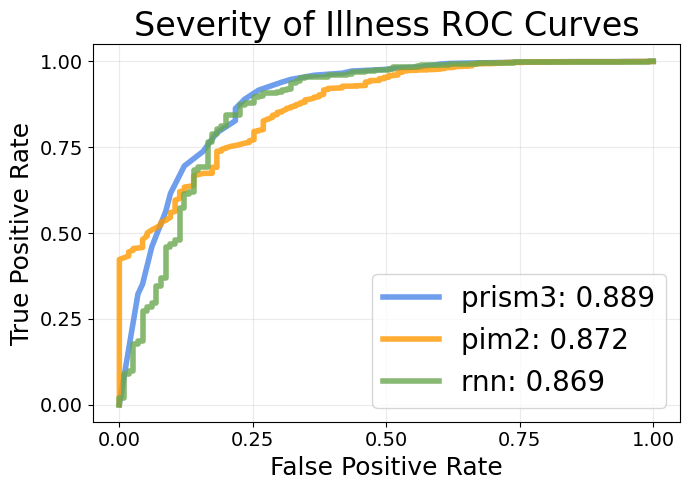

In [12]:
# plot rocs & display AUCs
plt.figure(figsize=(7, 5))
line_kwargs = {'linewidth': 4, 'alpha': 0.8}
plt.plot(prism3_roc[0], prism3_roc[1], label='prism3: %0.3f' % prism3_auc, color='#4A86E8', **line_kwargs)
plt.plot(pim2_roc[0], pim2_roc[1], label='pim2: %0.3f' % pim2_auc, color='#FF9900', **line_kwargs)
plt.plot(rnn_roc[0], rnn_roc[1], label='rnn: %0.3f' % rnn_auc, color='#6AA84F', **line_kwargs)
plt.legend(loc='lower right', fontsize=20)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Severity of Illness ROC Curves", fontsize=24)
plt.grid(alpha=0.25)
plt.tight_layout()

Notice how good this is considering we only did a few rounds of training!